In [1]:
%load_ext autoreload
%autoreload 2

## TODOs
- Make smoothing run in parallell to sorting depths
- Look into batched computation of alphas by binning (or otherwise grouping) by nx, ny. In one bin, we then compute `np.linspace(x1_cam, x2_cam*nx.max()/nx, nx.max())` whenever we overshoot. Maybe computing `power` is faster outside the loop in this way.
- Is batched rendering possible? Maybe we have to make major changes to do so, but that's probably the weakest joint. 
- Further explore: Is it faster to render float16 images? Doing the full calculation in float16 doesn't work, but maybe the rendering is okay?
- Look into masking outside the rendering loop also considering depth_map. Then we can skip the if condition in the loop.
- can we improve condition for skipping, i.e. `depths[i] > depth_map[y1:y2,x1:x2].max()` ? E.g. due to not investigating all x, y for depth estimation
- Make stuff hashable: think of speedups (depth_map, potentially? Maybe also others?)
- jit compilation?
- Bug: depending on `skip` parameter, the rendered pictures look different


# Scribble notebook
The plan is to use this to make first experiments, which will later be turned into a cleaner implementation. 
For now, it is based on https://github.com/thomasantony/splat/blob/master/notes/00_Gaussian_Projection.ipynb 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import spatial
from typing import List, Dict 
from copy import deepcopy
import warnings 
import random 
from tqdm import tqdm 
import time 

from utils.Camera import Camera
from utils.util_gau import load_ply, naive_gaussian, GaussianData
from utils.constants import * 
from pathlib import Path 
import multiprocessing as mp 
import functools
from decouple import config
from dataclasses import dataclass 
from typing import List, Tuple
from utils.Primitives import Gaussian, PrimitiveSet, PrimitiveSubset, MultiGaussian
from utils.ImageSegmenter import (
    IterativeImageSegmenter, 
    SubImage, 
    cut_image
)

In [3]:
gaussian_objects0 = load_ply(str(Path(config('MODEL_PATH'))/'debug/point_cloud/iteration_30000/point_cloud.ply'), dtype=np.float64, return_type='gm')


In [4]:
# n_rnd = len(gaussian_objects0) // 2
# n_render = n_rnd // 3

# rnd_ids = np.array(random.sample(range(len(gaussian_objects0)), n_rnd), dtype=int)
# rnd_obj = MultiGaussian(parent=gaussian_objects0, ids=rnd_ids)
# thresh = np.quantile(rnd_obj.min_scale, 1-n_render / len(rnd_obj))
# opacity_thresh = np.quantile(rnd_obj.opacity.reshape(-1), 1-n_render / len(rnd_obj))
# rnd_obj = rnd_obj.filter(lambda g: np.logical_and(g.min_scale > thresh, g.opacity.reshape(-1) > opacity_thresh))
# gaussian_objects = gaussian_objects0
# gaussian_objects.pos.mean(axis=0)

gaussian_objects = gaussian_objects0

In [5]:
gaussian_objects.pos[np.arange(10, dtype=int)].shape

(10, 3)

In [6]:
from utils.rendering import ParRenderer 

(w, h) = (400, 400)

renderer = ParRenderer(gaussian_objects)

camera = Camera(h, w, position=(-.2, 2., 1.4), target=(-.15, 1.5, .7))# target is pos for one of the gaussians
bitmap_parts = list(tqdm(renderer.plot_model_par_multiprimitives(camera, n_threads=20, skip=7000, K=None)))
# bitmap_parts = list(tqdm(gaussian_objects.get_bm_parts(camera, n_threads=20)))


# do alpha blending post-hoc
bitmap = np.zeros(bitmap_parts[0][0].shape)
alpha = np.zeros(bitmap_parts[0][1].shape)
for bm, al in bitmap_parts:
    tmp = (1-alpha)*al
    bitmap = bitmap + tmp[..., np.newaxis]*bm
    alpha = alpha + tmp

plt.figure(figsize=(6, 6))
plt.imshow(bitmap, vmin=0, vmax=1.0)
plt.show()


0it [00:00, ?it/s]

Sorting the gaussians by depth


3it [00:00,  4.59it/s]

sorted in time 0.64 s
Plotting with 281498 gaussians
prepped in time 0.00 s


35it [00:13,  1.60it/s]

In [ ]:
# # define utility functions for parallell computation

# def helper_multiprimitives(
#         indices: List[int], 
#         bitmap, 
#         alphas, 
#         # gaussian_objects: MultiGaussian, 
#         K=1000, 
#         depths=None, 
#         depth_map=None
#     ):
#     if K is None: 
#         bitmap, alphas = MultiGaussian(parent=gaussian_objects, ids=indices).render(bitmap, alphas, depths=depths, depth_map=depth_map)
#     else:
#         for ids in [indices[i*K:(i+1)*K] for i in range(len(indices) // K + int(len(indices) % K != 0))]:
#             bitmap, alphas = MultiGaussian(parent=gaussian_objects, ids=ids).render(bitmap, alphas, depths=depths, depth_map=depth_map)
#     return bitmap, alphas 

# def plot_model_par_multiprimitives(camera: Camera, gaussian_objects: MultiGaussian, n_threads:int=1, skip=10000, K=1000, depth_map=None):
#     """Parallellize image rendering using MultiGaussians.
#     Requires blending the segments later.
#     """
#     print('Sorting the gaussians by depth')
    
#     t0 = time.time()
#     depths = gaussian_objects.get_depth(camera)
#     indices = np.argsort(depths)
#     t1 = time.time()
#     print(f'sorted in time {t1-t0:.2f} s')
#     w, h = camera.w, camera.h
    
#     print('Plotting with', len(gaussian_objects), 'gaussians')
#     t0 = time.time()
#     bitmap = np.zeros((h, w, 3), np.float32)
#     alphas = np.zeros((h, w), np.float32)
#     gsns = (indices[i*skip:(i+1)*skip] for i in range(len(indices)//skip + int(len(indices)%skip != 0)))
#     t1 = time.time()
#     if depth_map is not None: depth_map = np.where(depth_map < np.inf, depth_map, depths.max())
#     print(f'prepped in time {t1-t0:.2f} s')
#     t0 = time.time()
#     if n_threads > 1:
#         with mp.Pool(n_threads) as pool:
#             for r in pool.imap(
#                 functools.partial(
#                     helper_multiprimitives,
#                     bitmap=bitmap,
#                     alphas=alphas, 
#                     K=K, 
#                     depths=depths,
#                     # gaussian_objects=gaussian_objects,
#                     depth_map=depth_map
#                 ), 
#                 gsns
#             ): 
#                 yield r 
#     else:
#         for g in gsns:
#             yield helper_multiprimitives(
#                     indices=g,
#                     # camera=camera,# None,
#                     bitmap=bitmap,
#                     alphas=alphas,
#                     K=K, 
#                     depths=depths,
#                     # gaussian_objects=gaussian_objects,
#                     depth_map=depth_map
#                 )
#     t1 = time.time()
#     print(f'rendered in time {t1-t0:.2f} s')
    

In [ ]:
# # render images using parallell processing and numpy array speedups
# (w, h) = (400, 400)

# camera = Camera(h, w, position=(-.2, 2., 1.4), target=(-.15, 1.5, .7))# target is pos for one of the gaussians
# bitmap_parts = list(tqdm(plot_model_par_multiprimitives(camera, gaussian_objects, n_threads=20, skip=7000, K=None)))


# # do alpha blending post-hoc
# bitmap = np.zeros(bitmap_parts[0][0].shape)
# alpha = np.zeros(bitmap_parts[0][1].shape)
# for bm, al in bitmap_parts:
#     tmp = (1-alpha)*al
#     bitmap = bitmap + tmp[..., np.newaxis]*bm
#     alpha = alpha + tmp

# plt.figure(figsize=(6, 6))
# plt.imshow(bitmap, vmin=0, vmax=1.0)
# plt.show()

In [ ]:
bitmap.dtype

dtype('float64')

In [ ]:
t0 = time.time()
filter_w, filter_h = 10, 10
rnd_obj.camera = camera 
depth_map = rnd_obj.get_depth_thresh(.9, 1., np.zeros((w,h)))
depth_map = np.where(depth_map < np.inf, depth_map, -np.inf)
depth_map = np.where(depth_map > -np.inf, depth_map, depth_map.max())
depth_map = sp.signal.convolve(depth_map, np.ones((filter_w, filter_h))/(filter_w*filter_h))

print(f'time elapsed: {time.time()-t0:.2f} s')
plt.imshow(np.where(depth_map < np.inf, depth_map, -1))
plt.show()

NameError: name 'rnd_obj' is not defined

0it [00:00, ?it/s]

Sorting the gaussians by depth
sorted in time 0.67 s
Plotting with 281498 gaussians
prepped in time 0.00 s


41it [00:03, 12.33it/s]


rendered in time 2.65 s


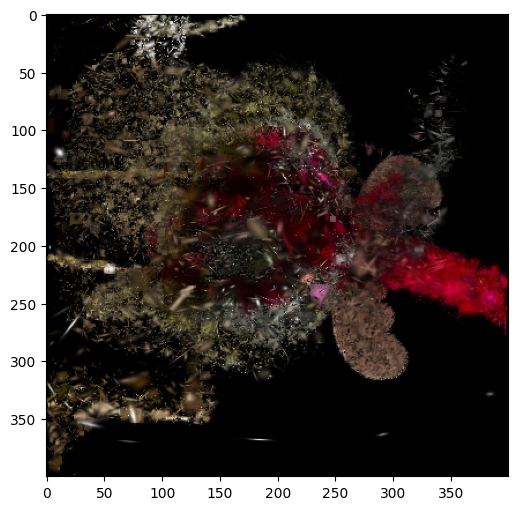

In [ ]:
# render images using parallell processing and numpy array speedups
(w, h) = (400, 400)


camera = Camera(h, w, position=(-.2, 2., 1.4), target=(-.15, 1.5, .7))# target is pos for one of the gaussians
# bitmap_parts = list(tqdm(plot_model_par_multiprimitives(camera, gaussian_objects, n_threads=20, skip=7000, K=None, depth_map=depth_map)))
bitmap_parts = list(tqdm(renderer.plot_model_par_multiprimitives(camera, n_threads=20, skip=7000, K=None, depth_map=depth_map)))

# do alpha blending post-hoc
bitmap = np.zeros(bitmap_parts[0][0].shape)
alpha = np.zeros(bitmap_parts[0][1].shape)
for bm, al in bitmap_parts:
    tmp = (1-alpha)*al
    bitmap = bitmap + tmp[..., np.newaxis]*bm
    alpha = alpha + tmp

plt.figure(figsize=(6, 6))
plt.imshow(bitmap, vmin=0, vmax=1.0)
plt.show()

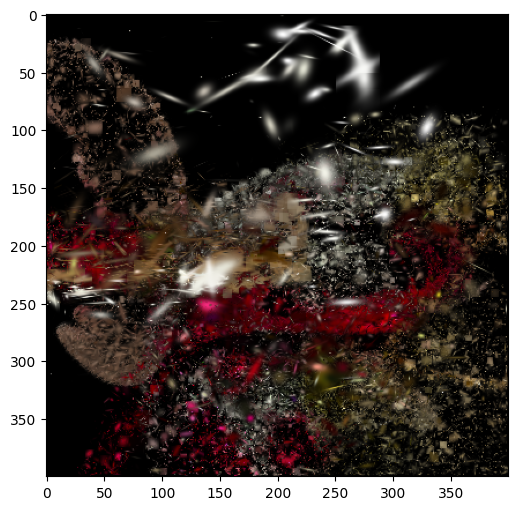

In [ ]:
from IPython.display import display, clear_output
import time
# %matplotlib widget
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
# draw as we generate
(w, h) = (400, 400)
camera = Camera(h, w, position=(-.2, 2, 1.), target=(-.15, 1.5, .6), up=np.array([0., 1., 0]))
# camera = Camera(h, w, position=(-.1, 1., 0), target=(-.15, 1.5, .7)) # target is pos for one of the gaussians
# bitmap_parts = plot_model_par_multiprimitives(camera, gaussian_objects, n_threads=20, skip=7000)
bitmap_parts = list(tqdm(renderer.plot_model_par_multiprimitives(camera, n_threads=20, skip=7000, K=None)))


# do alpha blending post-hoc
bitmap = np.zeros((w, h, 3))
alpha = np.zeros((w, h))
# i = 0
for bm, al in bitmap_parts:
    # print(i, end='\r')
    # i += 1
    bitmap = bitmap + ((1-alpha)*al)[..., np.newaxis]*bm
    alpha = alpha + (1-alpha)*al
    ax.cla()
    ax.imshow(bitmap, vmin=0, vmax=1.0)
    display(fig)
    clear_output(wait=True)
    


## Old Code
Testing out various ideas described in the blog. I might revisit them.

In [ ]:
# def plot_conics_and_bbs(gaussian_objects, camera: Camera, color: str='blue'):
#     # credit to https://github.com/thomasantony/splat/blob/master/notes/00_Gaussian_Projection.ipynb 
#     # Note: there are some things I would still like to change in this function (e.g. I'm pretty sure coordxy does not need four, but rather two, corners)
#     ax = plt.gca()

#     for g in gaussian_objects: #zip(gaussian_objects, colors):
#         assert isinstance(g, Gaussian)
#         (conic, bboxsize_cam, bbox_ndc) = g.get_conic_and_bb(
#             camera, 
#             optimal=True
#         )
#         if conic is None:
#             continue

#         A, B, C = conic
#         # coordxy is the correct scale to be used with gaussian and is already
#         # centered on the gaussian
#         coordxy = bboxsize_cam
#         x_cam = np.linspace(coordxy[0][0], coordxy[1][0], 100)
#         y_cam = np.linspace(coordxy[1][1], coordxy[2][1], 100) # how come the first axis has more than 2 dimensions here?
#         X, Y = np.meshgrid(x_cam, y_cam)
        
#         # 1-sigma ellipse # actually, I think this is the sqrt(3)-sigma ellipse. 
#         # F = A*X**2 + 2*B*X*Y + C*Y**2 - 3.00
#         F = np.sqrt(A*X**2 + 2*B*X*Y + C*Y**2) - 3.00 

#         bbox_screen = camera.ndc_to_pixel(bbox_ndc)

#         # Use bbox offset to position of gaussian in screen coords to position the ellipse
#         x_px = np.linspace(bbox_screen[0][0], bbox_screen[1][0], 100)
#         y_px = np.linspace(bbox_screen[2][1], bbox_screen[1][1], 100) # again, why this many dimensions?
#         X_px, Y_px = np.meshgrid(x_px, y_px)
#         F_val = 0.0
#         plt.contour(X_px, Y_px, F, [F_val])

#         # Plot a rectangle around the gaussian position based on bb
#         ul = bbox_screen[0,:2]
#         ur = bbox_screen[1,:2]
#         lr = bbox_screen[2,:2]
#         ll = bbox_screen[3,:2]
#         ax.add_patch(plt.Rectangle((ul[0], ul[1]), ur[0] - ul[0], lr[1] - ur[1], fill=False, alpha=1., color=color))


In [ ]:
# def plot_opacity_v(gaussian: Gaussian, camera: Camera, bitmap: np.ndarray, alphas: np.ndarray, alpha_thresh: float=None):
#     """Vectorized version of the plot_opacity function of the original repo - we want to loop as little as possible for speed"""
    
    
#     conic, bboxsize_cam, bbox_ndc = gaussian.get_conic_and_bb(camera, optimal=True) # different bounding boxes (active areas for gaussian)
#     # bboxsize_cam, bbox_ndc = gaussian.get_nonopt_bb(camera)
#     h, w = bitmap.shape[:2]
#     bbox_screen = camera.ndc_to_pixel(bbox_ndc, w, h)
    
#     if np.any(np.isnan(bbox_screen)):
#         return

#     ul = bbox_screen[0,:2] # Bounding box vertices 
#     ur = bbox_screen[1,:2]
#     ll = bbox_screen[3,:2]
    
#     y1 = max([int(np.floor(ul[1])), 0])
#     y2 = min([int(np.ceil(ll[1])), bitmap.shape[0]])
    
#     x1 = max([int(np.floor(ul[0])), 0])
#     x2 = min([int(np.ceil(ur[0])), bitmap.shape[1]])
#     nx = x2 - x1
#     ny = y2 - y1
#     if nx <= 0 or ny <= 0: return bitmap, alphas
    
#     # TODO: this was an attempt at checking whether we have rendered enough so that the alpha value in a pixel
#     # is so high that we do not need to keep rendering deeper Gaussians in that pixel. However, the logic below
#     # was slow enough that it did not pay off to implement this
#     # TODO: possibly we could be cleverer when checking alpha - e.g. by using information from the foreground.
#     # I am working on this

#     # midy = y1+ny//2
#     # midx = x1+nx//2
#     # # if alpha_thresh is not None and (alphas[y1:y2,x1:x2] >= alpha_thresh).sum() >= nx*ny/3: 
#     # #     return bitmap, alphas 
#     # if alpha_thresh is not None and min([ # check alpha on bb borders (heuristic)
#     #     # alphas[y1:y2, x1].max(),
#     #     # alphas[y1:y2, x2-1].max(),
#     #     # alphas[y1, x1:x2].max(),
#     #     # alphas[y2-1, x1:x2].max(),
#     #     alphas[midy, x1],
#     #     alphas[midy, x2-1],
#     #     alphas[y1, midx],
#     #     alphas[y2-1, midx],
#     #     alphas[midx,midx]
#     # ]) >= alpha_thresh: 
#     #     return bitmap, alphas
#     # conic = gaussian.get_conic(camera)
    
#     A, B, C = conic # precision matrix is (A, B; B, C)

#     # Extract out inputs for the gaussian
#     coordxy = bboxsize_cam
#     x_cam_1 = coordxy[0][0]   # ul
#     x_cam_2 = coordxy[1][0]   # ur
#     y_cam_1 = coordxy[1][1]   # ur (y)
#     y_cam_2 = coordxy[2][1]   # lr

#     opacity = gaussian.opacity 

#     camera_dir = gaussian.pos - camera.position
#     camera_dir = camera_dir / np.linalg.norm(camera_dir) # normalized camera viewing direction
#     color = gaussian.get_color(camera_dir)
#     y_cam, x_cam = np.meshgrid(np.linspace(y_cam_1, y_cam_2, ny), np.linspace(x_cam_1, x_cam_2, nx), indexing='ij')
#     power = -(A*x_cam**2 + C*y_cam**2)/2.0 - B * x_cam * y_cam
#     # power = np.clip(power, -np.inf, 0.)
#     alpha_ = opacity * np.exp(power)
#     bitmap[y1:y2, x1:x2] = bitmap[y1:y2, x1:x2] + ((1-alphas[y1:y2, x1:x2])*alpha_).reshape(ny, nx, 1) * color[0:3].reshape(1, 1, -1)
#     alphas[y1:y2, x1:x2] = alphas[y1:y2, x1:x2] + (1-alphas[y1:y2, x1:x2]) * alpha_ 
#     return bitmap, alphas 

# def plot_opacity_multi(gaussians: MultiGaussian, camera: Camera, bitmap: np.ndarray, alphas: np.ndarray, alpha_thresh: float=None):
#     """Vectorized version of the plot_opacity function of the original repo - we want to loop as little as possible for speed"""
#     def scale_wh(tnsr: np.ndarray, h: int, w: int):
#         # scale values of tnsr's -1st axis, which has length 2, from -1, 1 to resp. 0, h and 0, w
#         # replace this: np.array([(points_ndc[0] + 1) * width_half, (1.0 - points_ndc[1]) * height_half])
#         tnsr = np.stack([tnsr[:, :, 0]+1, 1-tnsr[:, :, 1]], axis=-1)
#         tnsr = tnsr * np.stack([np.ones(tnsr.shape[:-1])*h, np.ones(tnsr.shape[:-1])*w], axis=-1)
#         return tnsr / 2

#     conic_, bboxsize_cam, bbox_ndc = gaussians.get_conic_and_bb(camera, optimal=True) # different bounding boxes (active areas for gaussian)
#     h, w = bitmap.shape[:2]
#     # bbox_screen = camera.ndc_to_pixel(bbox_ndc, w, h)
#     bbox_screen = scale_wh(bbox_ndc, h, w)
    
#     if np.any(np.isnan(bbox_screen)):
#         return

#     ul = bbox_screen[:, 0,:2] # Bounding box vertices 
#     ur = bbox_screen[:, 1,:2]
#     ll = bbox_screen[:, 3,:2]
    
#     y1_ = np.maximum(np.floor(ul[:, 1]), np.zeros(len(gaussians))).astype(int)
#     x1_ = np.maximum(np.floor(ul[:, 0]), np.zeros(len(gaussians))).astype(int)

#     y2_ = np.minimum(np.ceil(ll[:, 1]), bitmap.shape[0]*np.ones(len(gaussians))).astype(int)
#     x2_ = np.minimum(np.ceil(ur[:, 0]), bitmap.shape[1]*np.ones(len(gaussians))).astype(int)

#     mask = np.logical_and(x2_ > x1_, y2_ > y1_)
#     x1_ = x1_[mask]
#     x2_ = x2_[mask]
#     y1_ = y1_[mask]
#     y2_ = y2_[mask]
#     conic_ = conic_[mask]

#     nx_ = x2_ - x1_
#     ny_ = y2_ - y1_
#     # if nx <= 0 or ny <= 0: return bitmap, alphas

#     # Extract out inputs for the gaussian
#     coordxy = bboxsize_cam[mask]
#     x_cam_1_ = coordxy[:, 0, 0]   # ul
#     x_cam_2_ = coordxy[:, 1, 0]   # ur
#     y_cam_1_ = coordxy[:, 1, 1]   # ur (y)
#     y_cam_2_ = coordxy[:, 2, 1]   # lr

#     opacity_ = gaussians.opacity[mask]

#     # camera_dir = gaussians.pos - camera.position.reshape((1, *camera.position.shape))
#     # camera_dir = camera_dir / np.linalg.norm(camera_dir, axis=-1) # normalized camera viewing direction
#     # color = gaussians.get_color(camera_dir)
#     color_ = gaussians.get_color(None)[mask] # TODO: would be nice if in MultiGaussian we could index with a mask prior to computations like these, rather than doing the computation and then selecting afterwards
    
    
#     for x_cam_1, x_cam_2, y_cam_1, y_cam_2, x1, x2, y1, y2, nx, ny, opacity, color, conic in zip(
#         x_cam_1_, 
#         x_cam_2_, 
#         y_cam_1_, 
#         y_cam_2_, 
#         x1_, 
#         x2_, 
#         y1_, 
#         y2_, 
#         nx_, 
#         ny_, 
#         opacity_, 
#         color_, 
#         conic_
#     ):
#         # if nx <= 0 or ny <= 0: continue
#         A, B, C = conic 
#         y_cam, x_cam = np.meshgrid(np.linspace(y_cam_1, y_cam_2, ny), np.linspace(x_cam_1, x_cam_2, nx), indexing='ij')
#         power = -(A*x_cam**2 + C*y_cam**2)/2.0 - B * x_cam * y_cam
#         # power = np.clip(power, -np.inf, 0.)
#         alpha_ = opacity * np.exp(power)
#         bitmap[y1:y2, x1:x2] = bitmap[y1:y2, x1:x2] + ((1-alphas[y1:y2, x1:x2])*alpha_).reshape(ny, nx, 1) * color[0:3].reshape(1, 1, -1)
#         alphas[y1:y2, x1:x2] = alphas[y1:y2, x1:x2] + (1-alphas[y1:y2, x1:x2]) * alpha_ 
#     return bitmap, alphas 
    
#     # below is WIP code
#     # np.linspace(np.zeros((2,)), np.array([1., 2.]), np.array([10, 20])) is not valid python, but
#     # np.linspace(np.zeros((2,)), np.array([1., 2.]), 10) is
#     n_gaussians = mask.sum()

#     ymin, ymax = np.min(y1_), np.max(y2_)
#     xmin, xmax = np.min(x1_), np.max(x2_)
#     alpha_computations = np.zeros((n_gaussians, ymax - ymin, xmax - xmin))
#     coefs = np.zeros(alpha_computations.shape)
#     side_coefs = np.zeros(alpha_computations.shape)

#     def fill_array(i: int):
#         """Take an index argument to fill the above tensor with values in a vectorized fashion"""
#         A, B, C = conic_[i][0], conic_[i][1], conic_[i][2]
#         y_cam, x_cam = np.meshgrid(np.linspace(y_cam_1_[i], y_cam_2_[i], ny_[i]), np.linspace(x_cam_1_[i], x_cam_2_[i], nx_[i]), indexing='ij')
#         power = -(A*x_cam**2 + C*y_cam**2)/2.0 - B * x_cam * y_cam
#         alpha_computations[i, y1_[i]-ymin:y2_[i]-ymin, x1_[i]-xmin:x2_[i]-xmin] = opacity_[i] * np.exp(power)
#         # return opacity_[i] * np.exp(power)
#     def prod_arr(i: int):
#         # return np.prod(1-alpha_computations[:i+1], axis=0)
#         coefs[i] = np.prod(1-alpha_computations[:i+1], axis=0)
#         # return np.prod(1-alpha_computations[:i+1], axis=0)
#     def other_coefs(i: int):
#         # let a:=alpha_computations
#         # return a[i] + (1-a[i]) * a[i-1] + (1-a[i])(1-a[i-1])*a[i-2] + ...
#         # Letting p[j] := (1-a[j]) * ... * (1-a[0]), then p is coefs, and we therefore return
#         # a[i] * p[i] / p[i] + a[i-1] * p[i] / p[i-1] + ...
#         side_coefs[i] = (coefs[i].reshape(1, *coefs[i].shape) * alpha_computations[:i+1] / coefs[:i+1]).sum(axis=0)
#         # side_coefs[i] = np.stack([coefs[i] / np.maximum(coefs[j], 1e-12) * alpha_computations[j] for j in range(i+1)], axis=0).sum(axis=0)
#         # return np.stack([coefs[i] / np.maximum(coefs[j], 1e-12) * alpha_computations[j] for j in range(i+1)], axis=0).sum(axis=0)
#     np.vectorize(fill_array)(range(n_gaussians))
#     np.vectorize(prod_arr)(range(n_gaussians)) # coefs[i] = (1-a[0]) * ... * (1-a[i])
#     np.vectorize(other_coefs)(range(n_gaussians)) 
#     # for func in [fill_array, prod_arr, other_coefs]:
#     #     for i in range(n_gaussians): func(i)
#     # np.apply_along_axis(fill_array, axis=0, arr=np.arange(n_gaussians, dtype=int).reshape(-1, 1))# (range(n_gaussians))
#     # np.apply_along_axis(prod_arr, axis=0, arr=np.arange(n_gaussians, dtype=int).reshape(-1, 1))# (range(n_gaussians)) # coefs[i] = (1-a[0]) * ... * (1-a[i])
#     # np.apply_along_axis(other_coefs, axis=0, arr=np.arange(n_gaussians, dtype=int).reshape(-1, 1))# (range(n_gaussians)) 

#     new_alphas = side_coefs + coefs * alphas[ymin:ymax, xmin:xmax].reshape(1, *alpha_computations.shape[1:]) 
#     # TODO: below, do I have to multiply by something more too?
#     new_colors = bitmap[ymin:ymax, xmin:xmax].reshape(1, *alpha_computations.shape[1:], 3) + new_alphas.reshape(*new_alphas.shape, 1) * color_[:, :3].reshape(-1, 1, 1, 3)
#     bitmap[ymin:ymax, xmin:xmax] = new_colors.sum(axis=0)
#     alphas[ymin:ymax, xmin:xmax] = new_alphas[-1]
#     return bitmap, alphas 

# # # Plot some Gaussians
# # loc_scaler = 1
# # scale_scaler = .05
# # rot_scaler = 10
# # n_gaussians = 50
# # loc_bias = 0. # np.ones(3,) * -.1

# # gaussians_debug = [
# #     Gaussian((np.random.rand(3, )-.5 + loc_bias)*2*loc_scaler, np.random.rand(3)*scale_scaler, np.random.rand(4)*rot_scaler, np.array([1.]), np.array([ 1.772484, -1.772484,  1.772484])) for _ in range(n_gaussians)
# # ]
# # gaussian_objects = gaussians_debug

# # (h, w) = (300, 400)
# # camera = Camera(h, w)
# # # Get gaussian indices sorted by depth
# # indices = np.argsort([g.get_depth(camera) for g in gaussian_objects]) # TODO: vectorize get_depth

# # # Initialize a bitmap with alpha channel of size w x h

# # bitmap = np.zeros((h, w, 3), np.float32)
# # alphas = np.zeros((h, w), np.float32)

# # plt.figure(figsize=(6,6))
# # for idx in indices:
# #     # bitmap, alphas = plot_opacity(gaussian_objects[idx], camera, bitmap, alphas)
# #     bitmap, alphas = plot_opacity_v(gaussian_objects[idx], camera, bitmap, alphas)
# # print(f'after execution, {bitmap.max()=}')
# # # Plot the bitmap
# # plt.imshow(bitmap, vmin=0, vmax=1.0)

# # plt.show()

In [ ]:
# Old classes for plotting which don't use MultiGaussian

# def helper_primitives(indices: List[int], camera, bitmap, alphas, alpha_thresh):
#     for idx in indices:
#         bitmap, alphas = plot_opacity_v(gaussian_objects[idx], camera, bitmap, alphas, alpha_thresh)
#     return bitmap, alphas 

# def plot_model_par_primitives(camera, gaussian_objects: List[Gaussian], alpha_thresh: float=None, n_threads:int=1):
#     """Parallellize image rendering by splitting the sorted list of Gaussians and rendering them individually.
#     Requires blending the segments later (for now).
#     """
#     print('Sorting the gaussians by depth')
#     indices = np.argsort([gau.get_depth(camera) for gau in gaussian_objects])# [::-1] # fast-ish. probably get_depth is slowing it down (vectorization/parallellization TODO)
#     w, h = camera.w, camera.h
    
#     print('Plotting with', len(gaussian_objects), 'gaussians')
#     bitmap = np.zeros((h, w, 3), np.float32)
#     alphas = np.zeros((h, w), np.float32)
#     skip = len(indices) // (3*n_threads) # arbitrary choice TODO
#     gsns = [indices[i*skip:(i+1)*skip] for i in range(len(indices)//skip + int(len(indices)%skip != 0))]
#     with mp.Pool(n_threads) as pool:
#         for r in pool.imap(
#             functools.partial(
#                 helper_primitives,
#                 alpha_thresh=alpha_thresh, 
#                 camera=camera,# None,
#                 bitmap=bitmap,
#                 alphas=alphas
#             ), 
#             gsns
#         ): 
#             yield r 

In [ ]:
# # Test IterativeImageSegmenter
# # The idea is to segment an image such that each segment has roughly the same number of Gaussians.
# # It's still not perfect (see blog)
# # TODO: There seems to be a bug that causes some of the splits to be sub-optimal. Have to investigate
# loc_scaler = 1
# scale_scaler = .03
# rot_scaler = 10
# n_gaussians = 30
# loc_bias = 0. 

# gaussians_debug = [
#     Gaussian((np.random.rand(3, )-.5 + loc_bias)*2*loc_scaler, np.random.rand(3)*scale_scaler, np.random.rand(4)*rot_scaler, np.array([1.]), np.array([ 1.772484, -1.772484,  1.772484])) for _ in range(n_gaussians)
# ]

# fig = plt.figure()
# ax = plt.gca()
# camera = Camera(100, 100)
# plot_conics_and_bbs(gaussians_debug, camera)
# image = SubImage(np.zeros((100, 100)), (0, 0), (100, 100), camera)
# pset = PrimitiveSet(gaussians_debug)
# sset = PrimitiveSubset(pset, list(range(len(gaussians_debug))))
# segmenter = IterativeImageSegmenter(sset, image, camera, thresh=3)

# for i in range(7):
#     bx, by = segmenter.cut(i)
#     ul, lr = segmenter.cuts[-1]['corners']
#     ymin, xmin = ul
#     ymax, xmax = lr 
#     if bx is None:
#         # plot y splitting line
#         plt.plot([xmin, xmax], [by]*2)
#         plt.text((xmax+xmin)/3*2, by, str(i))
#     else:
#         plt.plot([bx]*2, [ymin, ymax])
#         plt.text(bx, (ymin+ymax)/3*2, str(i))
    
# plt.xlim([0, camera.w])
# plt.ylim([0, camera.h])
# plt.grid(True)
# plt.show()
